In [1]:
%pylab inline
import xarray as xr

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.linear_model import LinearRegression

In [3]:
def anomaly(idata):
    """calculate anomaly"""
    
    clim=idata.groupby('time.month').mean(dim='time')
    anom=idata.groupby('time.month')-clim

    return anom

annual=lambda ivar: ivar.resample(time='A').mean(dim='time')

In [4]:
def gavg(d1):
    ## area-weighted average of d1
    weights = np.cos(np.deg2rad(d1.lat));weights.name='weights'
    d2=d1.weighted(weights)
    d3=d2.mean(dim=['lat','lon'])
    return d3

In [5]:
mod1=xr.open_dataset('/Users/ksmalley/multiple_regression/data/CCMI_monthly_CNRM-CM5-3_refC2_allVars.nc')
mod1['plev']=mod1.plev/100
mod1.plev

<xarray.DataArray 'plev' (plev: 31)>
array([1.00e+03, 8.50e+02, 7.00e+02, 5.00e+02, 4.00e+02, 3.00e+02, 2.50e+02,
       2.00e+02, 1.70e+02, 1.50e+02, 1.30e+02, 1.15e+02, 1.00e+02, 9.00e+01,
       8.00e+01, 7.00e+01, 5.00e+01, 3.00e+01, 2.00e+01, 1.50e+01, 1.00e+01,
       7.00e+00, 5.00e+00, 3.00e+00, 2.00e+00, 1.50e+00, 1.00e+00, 5.00e-01,
       3.00e-01, 2.00e-01, 1.00e-01])
Coordinates:
  * plev     (plev) float64 1e+03 850.0 700.0 500.0 400.0 ... 0.5 0.3 0.2 0.1

In [6]:
##The dates used in the paper ranged from January 2000 - December 2097 not 2000 - 2100
h2o=annual(gavg(mod1.vmrh2o.sel(lat=slice(-30,30)).sel(plev=80))).sel(time=slice('2000','2097'))*1e6 ##I used 80-hPa not 70-hPa h2o
h2o -= average(h2o)##I used annual h2o anomalies (doesn't change the outcome)

In [7]:
##The dates used in the paper ranged from January 2000 - December 2097 not 2000 - 2100
t500=annual(gavg(mod1.ta.sel(lat=slice(-30,30)).sel(plev=500))).sel(time=slice('2000','2097'))
t500 -= average(t500)##I used annual 500-hPa temperature anomalies (doesn't change the outcome)

qdot=annual(gavg(mod1.tntsw.sel(lat=slice(-30,30)).sel(plev=80))).sel(time=slice('2000','2097'))+\
        annual(gavg(mod1.tntlw.sel(lat=slice(-30,30)).sel(plev=80))).sel(time=slice('2000','2097'))
qdot *= 86400.
qdot *= ((1000./80.)**(2./7.))## I was converting qdot into changes in potential temperature
qdot -= average(qdot)##I used annual 80-hPa qdot anomalies (doesn't change the outcome)

qbo=anomaly(mod1.ua.sel(plev=50,lat=0,method='nearest').mean(dim='lon').sel(time=slice('2000','2097')))
qbo=annual(qbo/qbo.std())
idata=np.column_stack([t500,qdot,qbo])

In [8]:
reg = LinearRegression().fit(idata,h2o)
reg.coef_

array([ 0.53385196, -0.04849185, -0.06339671])

Text(0, 0.5, 'actual')

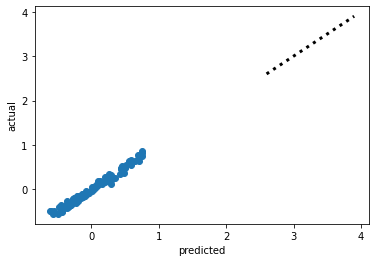

In [9]:
## plot up predicted & actual values
plot(reg.predict(idata),h2o,'o')
plot(np.linspace(2.6,3.9),np.linspace(2.6,3.9),color='k',ls=':',lw=3)
xlabel('predicted');ylabel('actual')

In [10]:
def detrend(x):
    p=x.polyfit(dim='time',deg=1)
    fit=xr.polyval(x.time,p.polyfit_coefficients)
    return np.array(x-fit)

In [11]:
def detrendAnom(cut,anom):                                                                                     
    #****************************************************************************
    #Purpose: detrend data using a boxcar filter                                                               
    #                                                                                                          
    #Inputs:                                                                                                   
    #  cut: cutoff frequency                                                                                   
    #  anom: anomoly values                                                                                    
    #                                                                                                          
    #Output:                                                                                                   
    #  varfft: detrended data                                                                                  
    #                                                                                                          
    #****************************************************************************
    
    from numpy import fft                                                                                      
    
    cuttoff    = cut                                                                                           
    varFFT     = fft.fft(anom)                                                                                 
    period     = 1/fft.fftfreq(varFFT.size,d = 1.0)                             
    varFFT    *= (abs(period) < cut)                                                                           
    inverseFFT = fft.ifft(varFFT)                                                                              
    varfft     = inverseFFT                                                                                    
    varfft     = (varfft).real                                                                                 
    
    return varfft    

In [12]:
#idata2=np.column_stack([detrend(ii) for ii in [t500,qdot,qbo]])
idata2=np.column_stack([detrendAnom(10,ii) for ii in [t500,qdot,qbo]])
#reg = LinearRegression().fit(idata2,detrend(h2o))
reg = LinearRegression().fit(idata2,detrendAnom(10,h2o))
reg.coef_

<ipython-input-11-2d4e9a0d879c>:18: RuntimeWarning: divide by zero encountered in true_divide
  period     = 1/fft.fftfreq(varFFT.size,d = 1.0)


array([ 0.51449821, -0.16056953, -0.06300657])

Text(0, 0.5, 'actual')

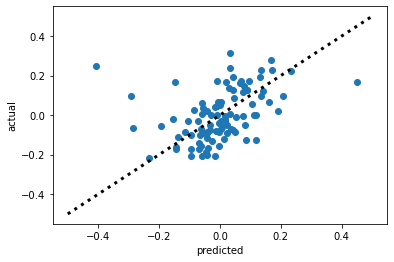

In [160]:
## plot up predicted & actual values
plot(reg.predict(idata2),detrend(h2o),'o')
plot(np.linspace(-0.5,0.5),np.linspace(-0.5,0.5),color='k',ls=':',lw=3)
xlabel('predicted');ylabel('actual')